#Zasoby

* Use custom holidays in a time-series forecasting model

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/time-series-forecasting-holidays-tutorial
* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series

#Cele

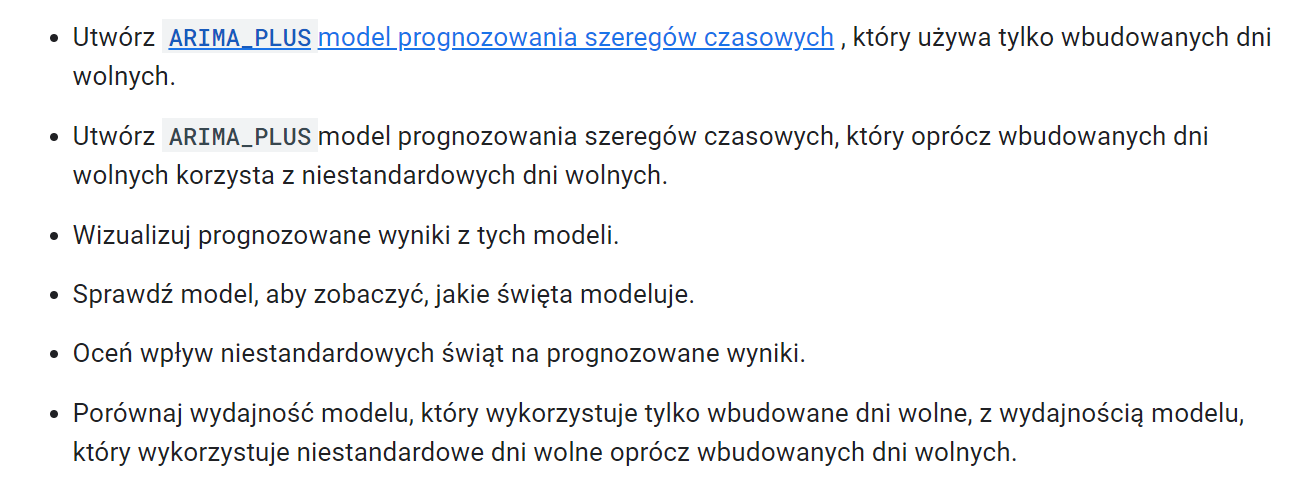

#Przygotuj dane szeregów czasowych (Krok 1)

* `DATETIME_TRUNC(datehour, DAY)` DATETIME_TRUNC służy do obcięcia daty i godziny do najbliższego dnia. Wynik jest zapisywany w nowej kolumnie o nazwie date. Oznacza to, że nowa tabela będzie zawierać tylko datę (bez godziny i minut).

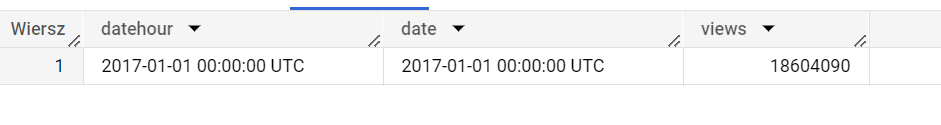

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE `pmackowka_us.table_0142`
AS
SELECT
  DATETIME_TRUNC(datehour, DAY) AS date,
  SUM(views) AS views
FROM
  `bigquery-public-data.wikipedia.pageviews_*`
WHERE
  datehour >= '2017-01-01'
  AND datehour < '2023-01-01'
  AND title = 'Google_I/O'
GROUP BY
  DATETIME_TRUNC(datehour, DAY)

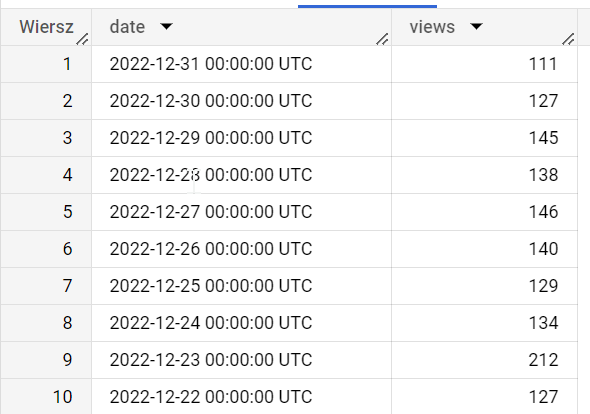

#Utwórz model prognozowania szeregów czasowych, który korzysta z wbudowanych dni wolnych (Krok 2)

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `pmackowka_us.model_0144`
  OPTIONS (
    model_type = 'ARIMA_PLUS',
    holiday_region = 'US',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'views',
    data_frequency = 'DAILY', # Częstotliwość danych wejściowych szeregów czasowych
    horizon = 365)
AS
SELECT
  *
FROM
  `pmackowka_us.table_0142`
WHERE
  date < '2022-01-01';

#Wizualizuj prognozowane wyniki (Krok 3)

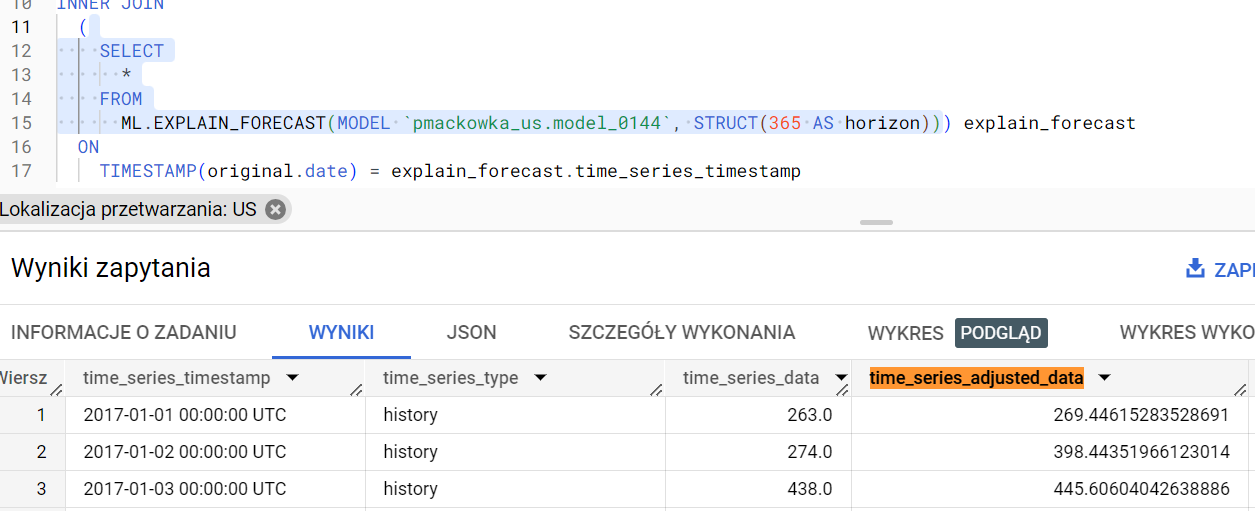

In [ ]:
%%bigquery

SELECT
  original.date,
  original.views AS original_views,
  explain_forecast.time_series_adjusted_data AS adjusted_views_without_custom_holiday,
FROM
  `pmackowka_us.table_0142` original

INNER JOIN
  (
    SELECT
      *
    FROM
      ML.EXPLAIN_FORECAST(MODEL `pmackowka_us.model_0144`, STRUCT(365 AS horizon))) explain_forecast
  ON
    TIMESTAMP(original.date) = explain_forecast.time_series_timestamp
ORDER BY
  original.date;

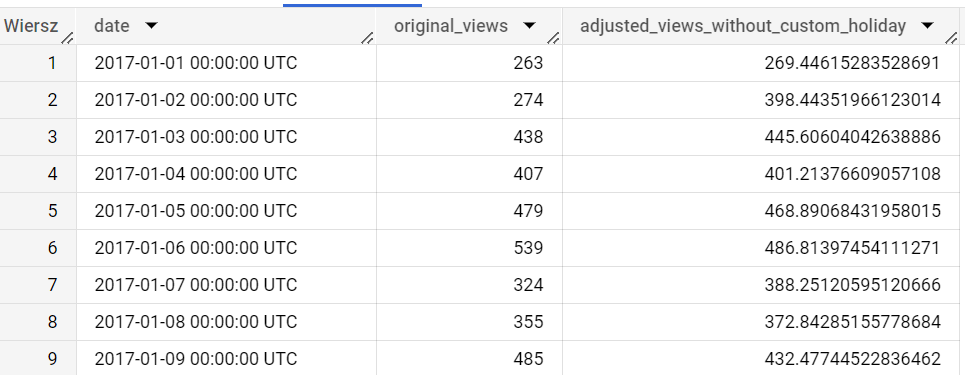

* Jak widać, model prognostyczny całkiem dobrze oddaje ogólny trend. Nie rejestruje jednak zwiększonego ruchu związanego z poprzednimi zdarzeniami I/O Google i nie jest w stanie wygenerować dokładnej prognozy.

* W następnych sekcjach pokazano, jak radzić sobie z niektórymi z tych ograniczeń.

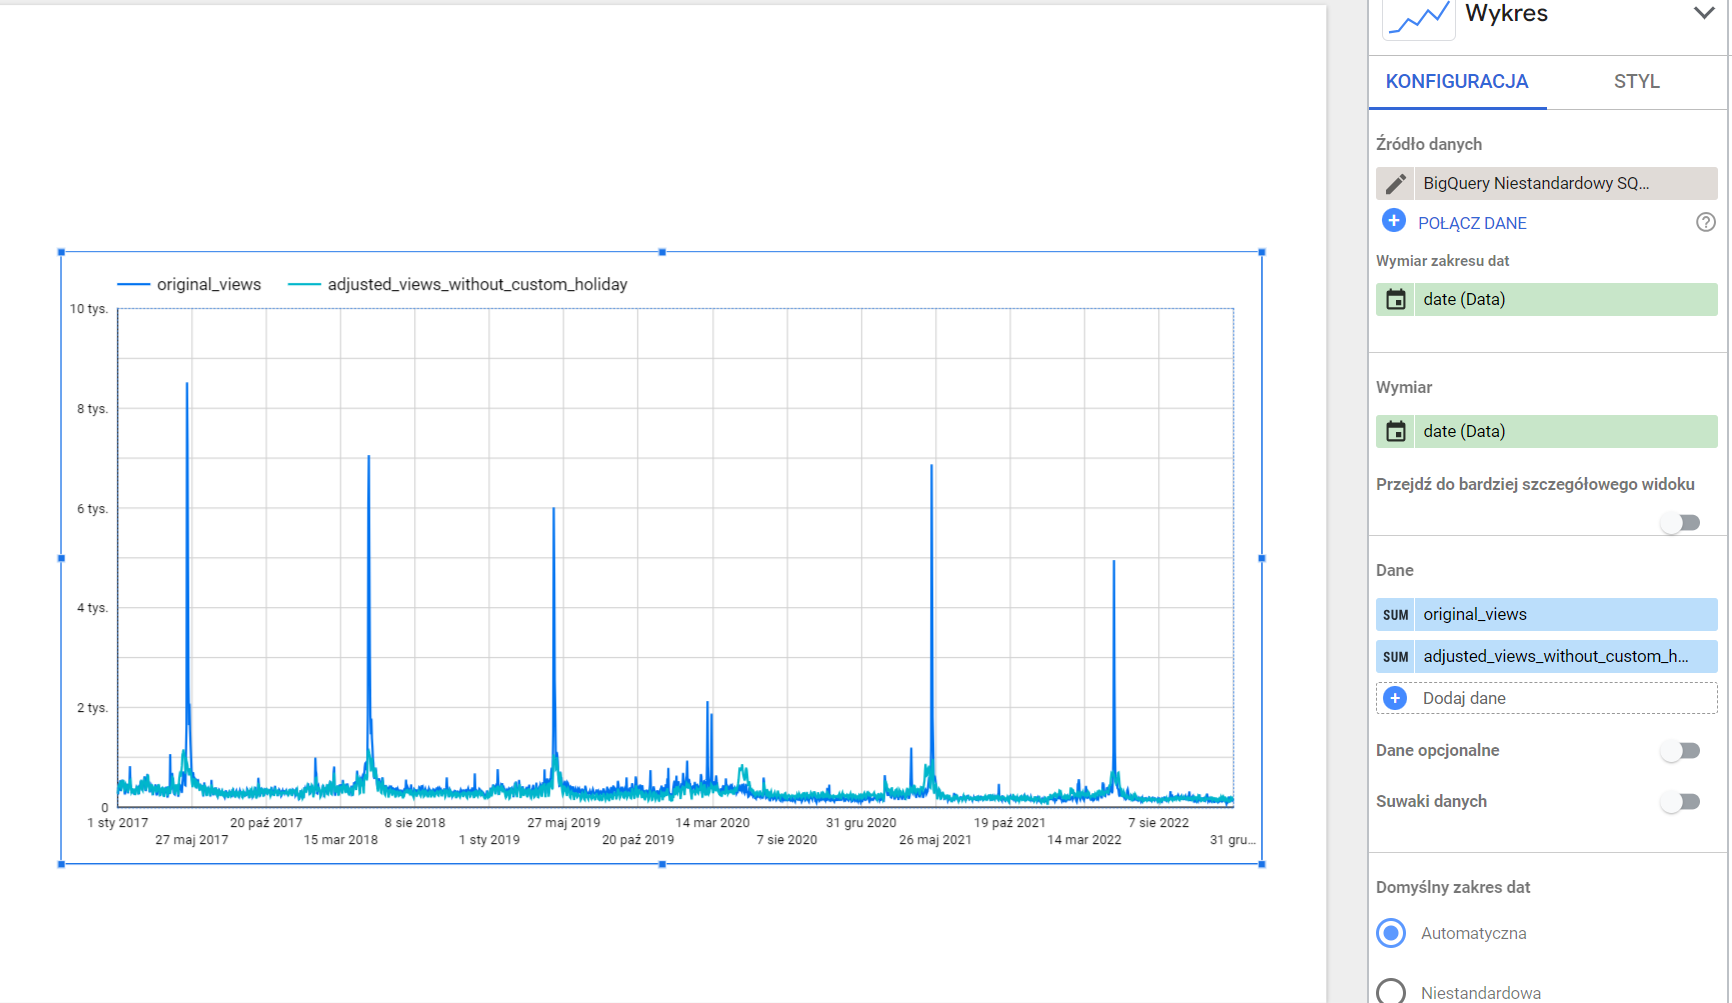

#Utwórz model prognozowania szeregów czasowych, który korzysta z wbudowanych i niestandardowych dni wolnych (Krok 4)

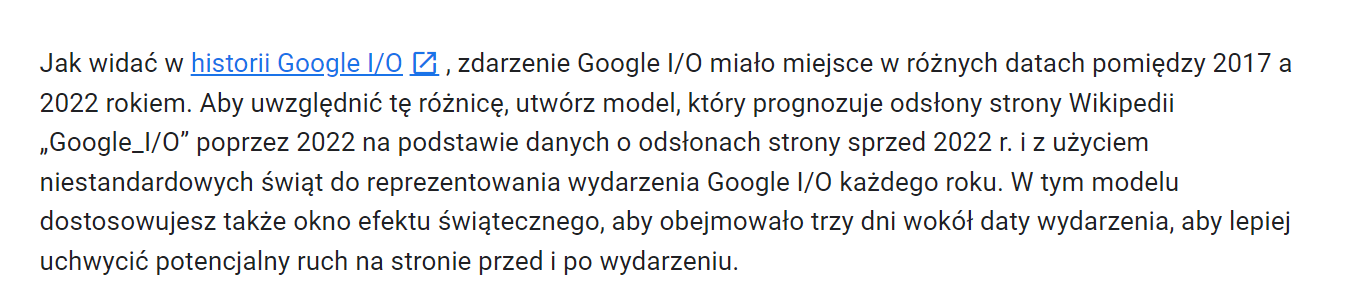

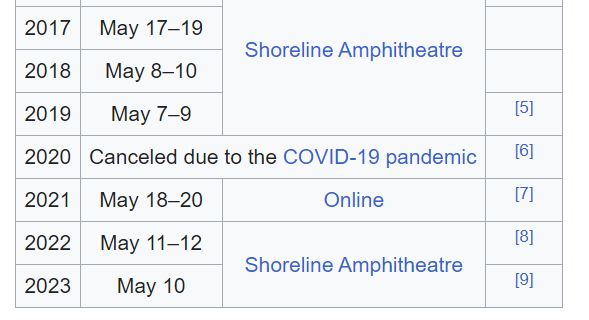

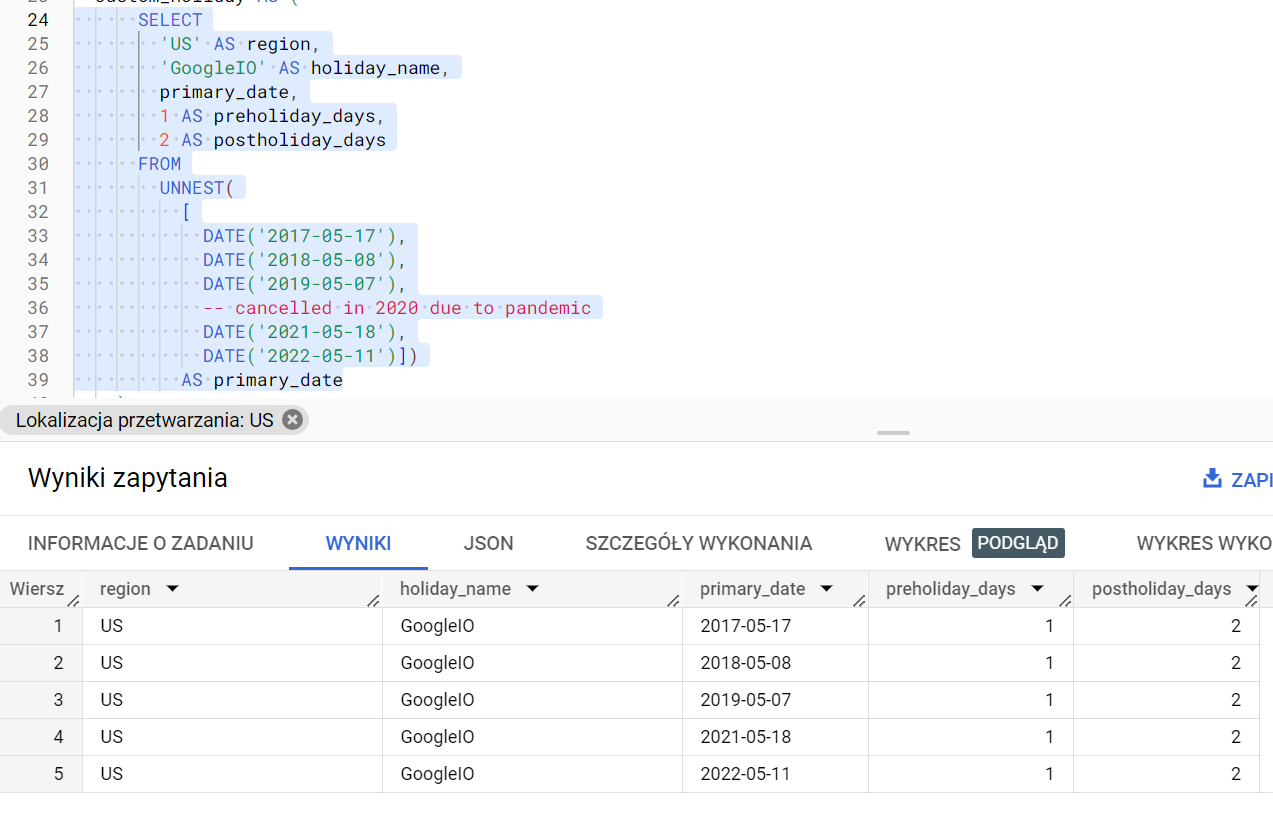

In [ ]:
%%bigquery

  CREATE OR REPLACE MODEL `pmackowka_us.model_0145`
  OPTIONS (
    model_type = 'ARIMA_PLUS',
    holiday_region = 'US',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'views',
    data_frequency = 'DAILY',
    horizon = 365)
AS (
  training_data AS (
      SELECT
        *
      FROM
        `pmackowka_us.table_0142`
      WHERE
        date < '2022-01-01'
    ),
  custom_holiday AS (
      SELECT
        'US' AS region,
        'GoogleIO' AS holiday_name,
        primary_date,
        1 AS preholiday_days,
        2 AS postholiday_days
      FROM
        UNNEST(
          [
            DATE('2017-05-17'),
            DATE('2018-05-08'),
            DATE('2019-05-07'),
            -- cancelled in 2020 due to pandemic
            DATE('2021-05-18'),
            DATE('2022-05-11')])
          AS primary_date
    )
);

#Wizualizuj prognozowane wyniki (Krok 5)

* Po utworzeniu modelu z wykorzystaniem niestandardowych świąt połącz oryginalne dane z tabeli `pmackowka_us.table_0142` z prognozowaną wartością z `ML.EXPLAIN_FORECAST` funkcji, a następnie zwizualizuj ją za pomocą Looker Studio:

In [ ]:
%%bigquery

SELECT
  original.date,
  original.views AS original_views,
  explain_forecast.time_series_adjusted_data AS adjusted_views_with_custom_holiday,
FROM
  `pmackowka_us.table_0142` original
INNER JOIN
  (
    SELECT
      *
    FROM
      ML.EXPLAIN_FORECAST(MODEL `pmackowka_us.model_0145`,STRUCT(365 AS horizon))) explain_forecast

  ON TIMESTAMP(original.date) = explain_forecast.time_series_timestamp
ORDER BY
  original.date;

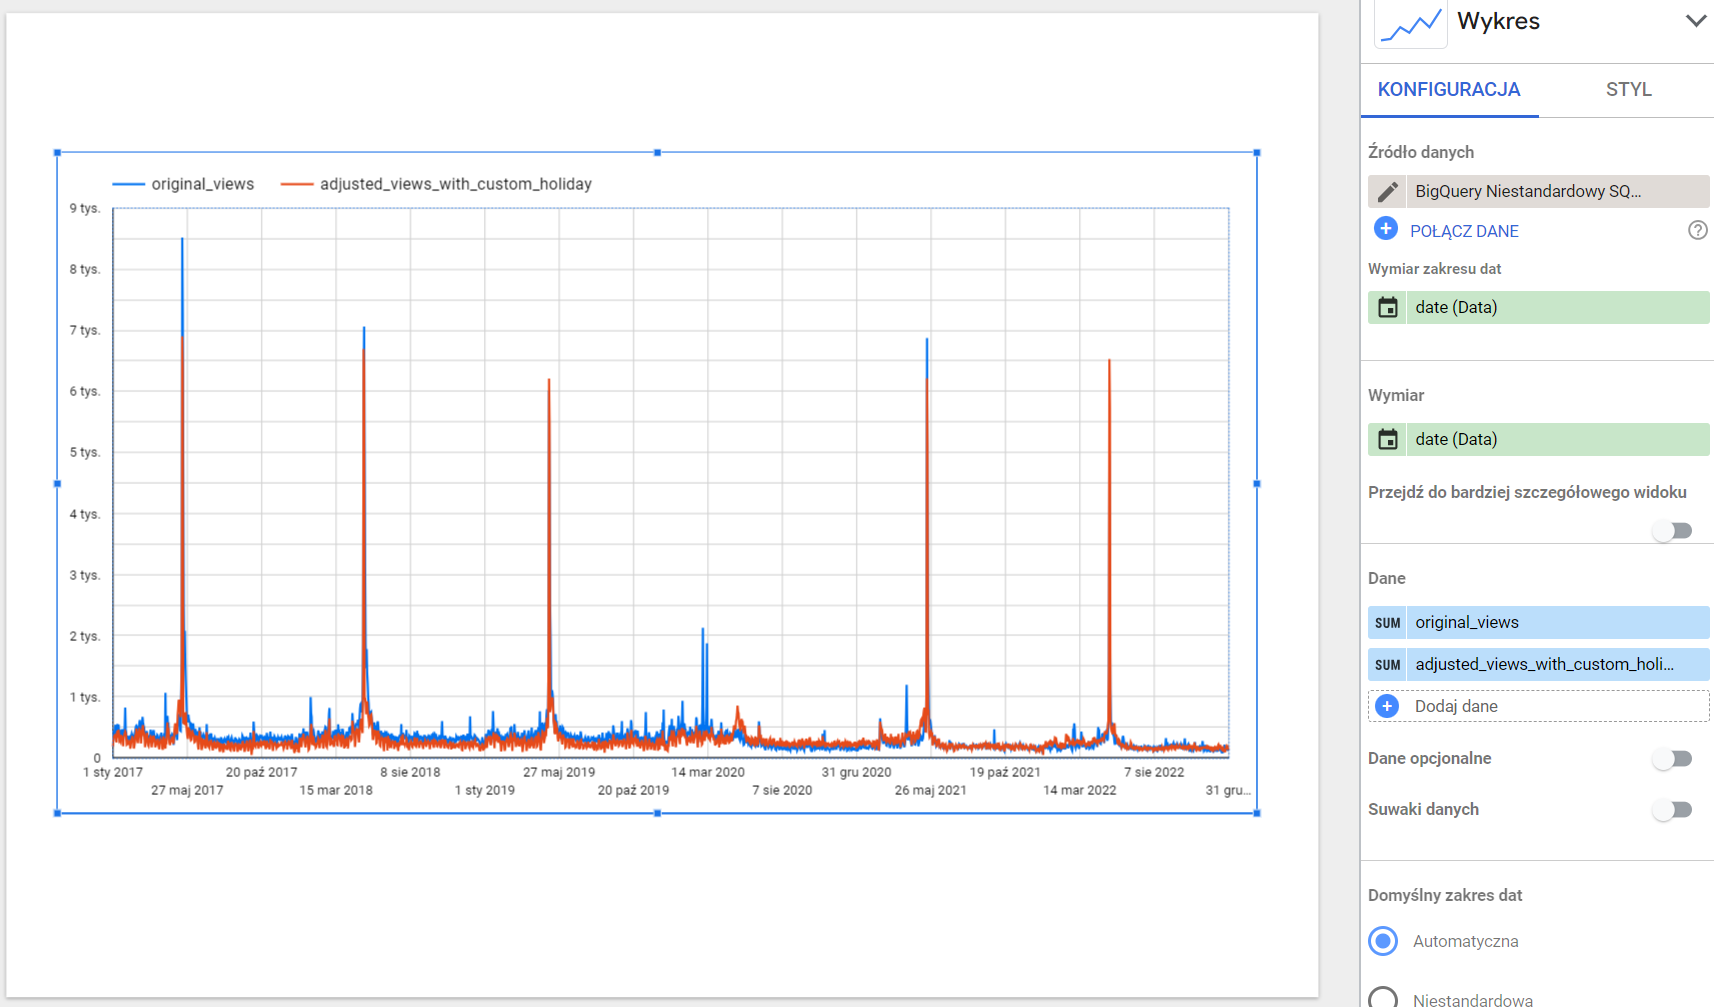

#Sprawdź informacje o wakacjach (Krok 5)

In [ ]:
%%bigquery

SELECT *
FROM
  ML.HOLIDAY_INFO(MODEL `pmackowka_us.model_0145`);

#Oceń skutki niestandardowych świąt (Krok 6)

* Wyniki pokazują, że Google I/O w dużym stopniu przyczynia się do efektu wakacyjnego w prognozowanych wynikach

In [ ]:
%%bigquery

SELECT
  time_series_timestamp,
  holiday_effect_GoogleIO,
  holiday_effect_US_Juneteenth,
  holiday_effect_Christmas,
  holiday_effect_NewYear
FROM
  ML.EXPLAIN_FORECAST(model `pmackowka_us.model_0145`, STRUCT(365 AS horizon))
WHERE holiday_effect != 0;

#Porównaj wydajność modelu (Krok 7)

* Użyj tej `ML.EVALUATE` funkcji, aby porównać wydajność pierwszego modelu utworzonego bez niestandardowych świąt i drugiego modelu utworzonego z niestandardowymi świętami. Aby zobaczyć, jak drugi model radzi sobie z prognozowaniem przyszłego niestandardowego święta, ustaw zakres czasu na tydzień Google I/O w 2022 r.:

* Wyniki pokazują, że drugi model oferuje znaczną poprawę wydajności:

In [ ]:
%%bigquery

SELECT
  "original" AS model_type,
  *
FROM
  ml.evaluate(MODEL `pmackowka_us.model_0144`,
    (
      SELECT
        *
      FROM
        `pmackowka_us.table_0142`
      WHERE
        date >= '2022-05-08'
        AND date < '2022-05-12'
    ),
    STRUCT(
      365 AS horizon,
      TRUE AS perform_aggregation))

UNION ALL

SELECT
  "with_custom_holiday" AS model_type,
  *
FROM
  ml.evaluate(MODEL `pmackowka_us.model_0145`,
    (
      SELECT
        *
      FROM
        `pmackowka_us.table_0142`
      WHERE
        date >= '2022-05-08'
        AND date < '2022-05-12'
    ),
    STRUCT(
      365 AS horizon,
      TRUE AS perform_aggregation));

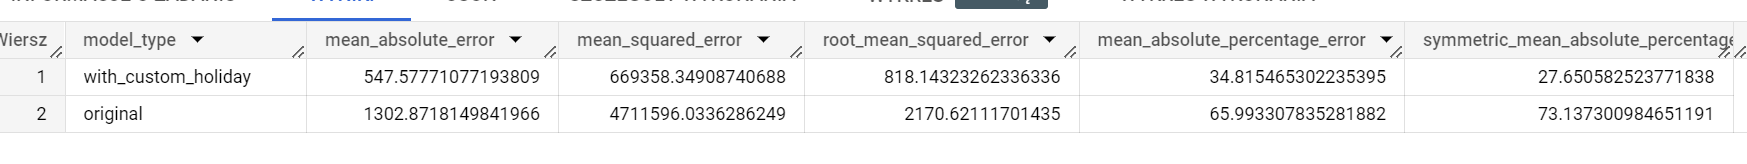